In [ ]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime , timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit ,GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder , LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akshay
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting


100%|██████████| 480k/480k [00:00<00:00, 471MB/s]

In [ ]:
df = pd.read_csv("/content/sales-forecasting/train.csv")

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [ ]:
df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [ ]:
df['Sales'].describe()

,Sales
count,9800.000000
mean,230.769059
std,626.651875
min,0.444000
25%,17.248000
50%,54.490000
75%,210.605000
max,22638.480000


In [ ]:
df['Category'].unique()


array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

Text(0, 0.5, 'Total Sales')

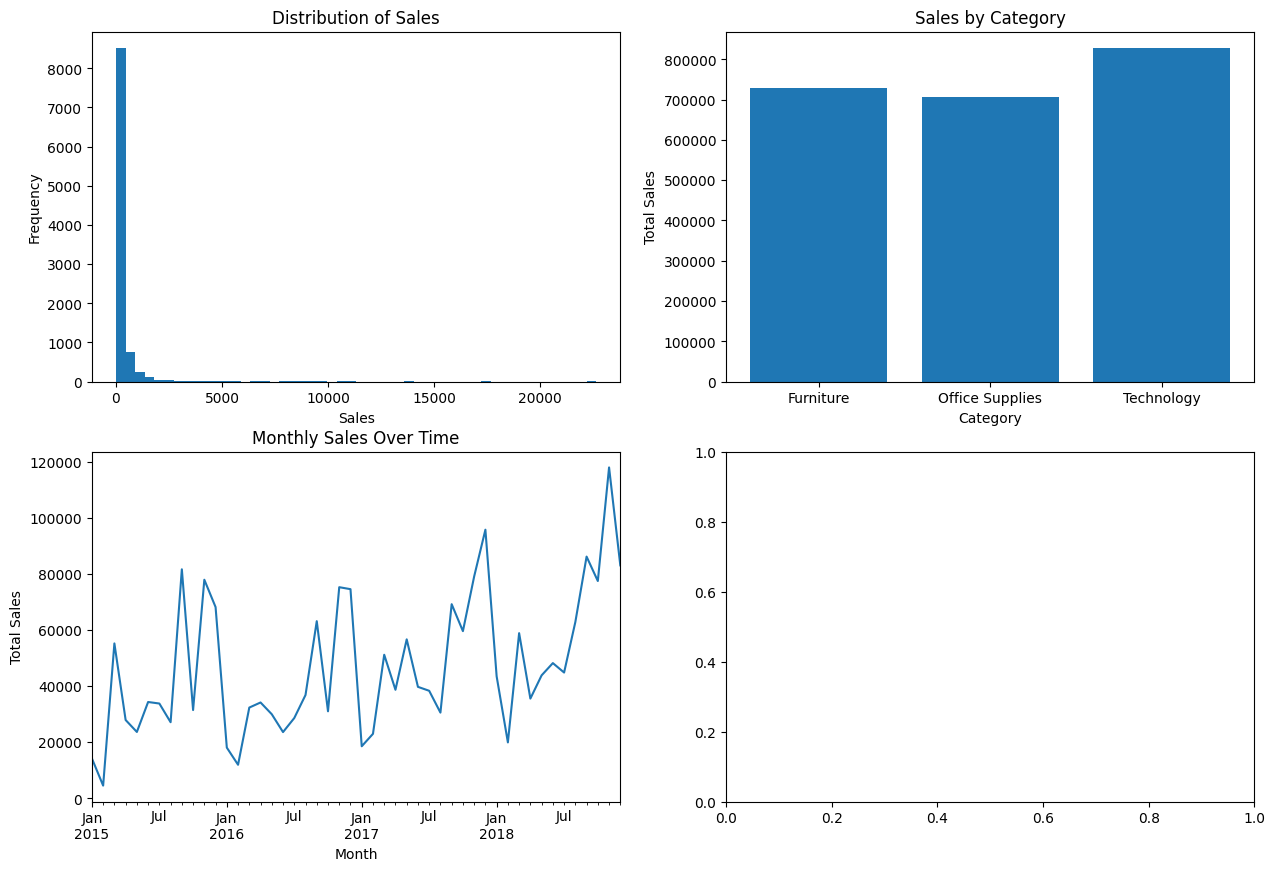

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,10))

# 1. Distribution of sales
axes[0,0].hist(df['Sales'], bins=50)
axes[0,0].set_title('Distribution of Sales')

axes[0,0].set_xlabel('Sales')
axes[0,0].set_ylabel('Frequency')


# Sales by category
category_sales = df.groupby('Category')['Sales'].sum()
axes[0,1].bar(category_sales.index, category_sales.values)
axes[0,1].set_title('Sales by Category')
axes[0,1].set_xlabel('Category')
axes[0,1].set_ylabel('Total Sales')

#Sales over time
df_temp = df.copy()
df_temp['Order Date'] = pd.to_datetime(df_temp['Order Date'], format='%d/%m/%Y')
df_temp.set_index('Order Date', inplace=True)
monthly_sales = df_temp['Sales'].resample('M').sum()
monthly_sales.plot(ax=axes[1,0])
axes[1,0].set_title('Monthly Sales Over Time')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Total Sales')



In [ ]:
df_clean = df.copy()


In [ ]:
# Handle missing values
initial_rows = len(df_clean)
print(f"Rows after removing missing values: {len(df_clean)}")
df_clean = df_clean.dropna(subset = ['Sales','Order Date'])
print(f"Rows removed: {initial_rows - len(df_clean)}")

Rows after removing missing values: 9800
Rows removed: 0


In [ ]:
# Convert the Date columns to dateTime
df_clean['Order Date'] = pd.to_datetime(df_clean['Order Date'], format='%d/%m/%Y')
df_clean['Ship Date'] = pd.to_datetime(df_clean['Ship Date'], format='%d/%m/%Y')

print(f"Date range: {df_clean['Order Date'].min()} to {df_clean['Order Date'].max()}")

Date range: 2015-01-03 00:00:00 to 2018-12-30 00:00:00


In [ ]:
# Remove Outliers using IQR Method

"""
df.quantile(0.25) = q1
df.quantile(0.75) = q3
df.quantile(0.5) = q2

"""

Q1 = df_clean['Sales'].quantile(0.25)
Q3 = df_clean['Sales'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_clean[(df_clean['Sales'] >= lower_bound) & (df_clean['Sales'] <= upper_bound)]

In [ ]:
# datetime features
df_clean['Year'] = df_clean['Order Date'].dt.year
df_clean['Month'] = df_clean['Order Date'].dt.month
df_clean['Day'] = df_clean['Order Date'].dt.day
df_clean['Day of Week'] = df_clean['Order Date'].dt.dayofweek
df_clean['Delivery Duration'] = (df_clean['Ship Date'] - df_clean['Order Date']).dt.days
df_clean['Quarter'] = df_clean['Order Date'].dt.quarter
df_clean['WeekOfYear'] = df_clean['Order Date'].dt.isocalendar().week.astype(int)
df_clean['IsWeekend'] = df_clean['Day of Week'].isin([5, 6]).astype(int)

# Check which countries does the IsHoliday supports

# Create cyclical encoding for temporal features
df_clean['Month_Sin'] = np.sin(2 * np.pi * df_clean['Month'] / 12)
df_clean['Month_Cos'] = np.cos(2 * np.pi * df_clean['Month'] / 12)
df_clean['Day_Sin'] = np.sin(2 * np.pi * df_clean['Day'] / 31)
df_clean['Day_Cos'] = np.cos(2 * np.pi * df_clean['Day'] / 31)

# Sort by 'Order Date' to ensure correct time-series operations
df_clean = df_clean.sort_values(by='Order Date').reset_index(drop=True)

# Lag features
for lag in [1, 7, 14, 30]:
    # Apply shift directly on the 'Sales' column after sorting
    df_clean[f'Sales_Lag_{lag}'] = df_clean['Sales'].shift(lag)

#Rolling stats
for window in [7, 14, 30, 90]:
    # Apply rolling directly on the 'Sales' column after sorting
    df_clean[f'Sales_Rolling_Mean_{window}'] = df_clean['Sales'].rolling(window=window).mean()
    df_clean[f'Sales_Rolling_Std_{window}'] = df_clean['Sales'].rolling(window=window).std()

In [ ]:
df_clean

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales_Lag_14,Sales_Lag_30,Sales_Rolling_Mean_7,Sales_Rolling_Std_7,Sales_Rolling_Mean_14,Sales_Rolling_Std_14,Sales_Rolling_Mean_30,Sales_Rolling_Std_30,Sales_Rolling_Mean_90,Sales_Rolling_Std_90
0,7981,CA-2015-103800,2015-01-03,2015-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,740,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,741,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,742,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1760,CA-2015-141817,2015-01-05,2015-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8650,1297,CA-2018-115427,2018-12-30,2019-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,Fairfield,...,7.968,78.8528,185.702286,118.366127,152.547429,139.122349,98.501933,123.269815,98.984287,118.467471
8651,5092,CA-2018-156720,2018-12-30,2019-01-03,Standard Class,JM-15580,Jill Matthias,Consumer,United States,Loveland,...,34.580,27.1680,156.177143,135.865477,150.293429,141.417325,97.697133,123.829144,98.760909,118.630951
8652,1298,CA-2018-115427,2018-12-30,2019-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,Fairfield,...,12.530,7.4000,115.940571,126.753190,150.878429,140.819278,98.141133,123.517699,98.470420,118.791358
8653,909,CA-2018-143259,2018-12-30,2019-01-03,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,...,19.600,2.4800,109.034286,128.992548,153.248143,138.703430,99.817667,122.511739,98.766153,118.642354


In [ ]:
df_clean.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [ ]:
# Encode categorical variables
CATEGORICAL_COLS = [ 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']

NUMERIC_COLS = ['Sales']

In [ ]:
for col in CATEGORICAL_COLS:
  le = LabelEncoder()
  df_clean[f'{col}_Encoded'] = le.fit_transform(df_clean[col])

In [ ]:
#Aggregate to daily sales

daily_sales = df_clean.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.set_index('Order Date')

In [ ]:
# Test of stationarity - ADF Test (Augumented Dicky Fuller Test)
adf_result = adfuller(daily_sales['Sales'].dropna())

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Stationary : {'Yes' if adf_result[1] < 0.05 else 'No'}")

ADF Statistic: -5.142619304696869
p-value: 1.1501010250579144e-05
Stationary : Yes


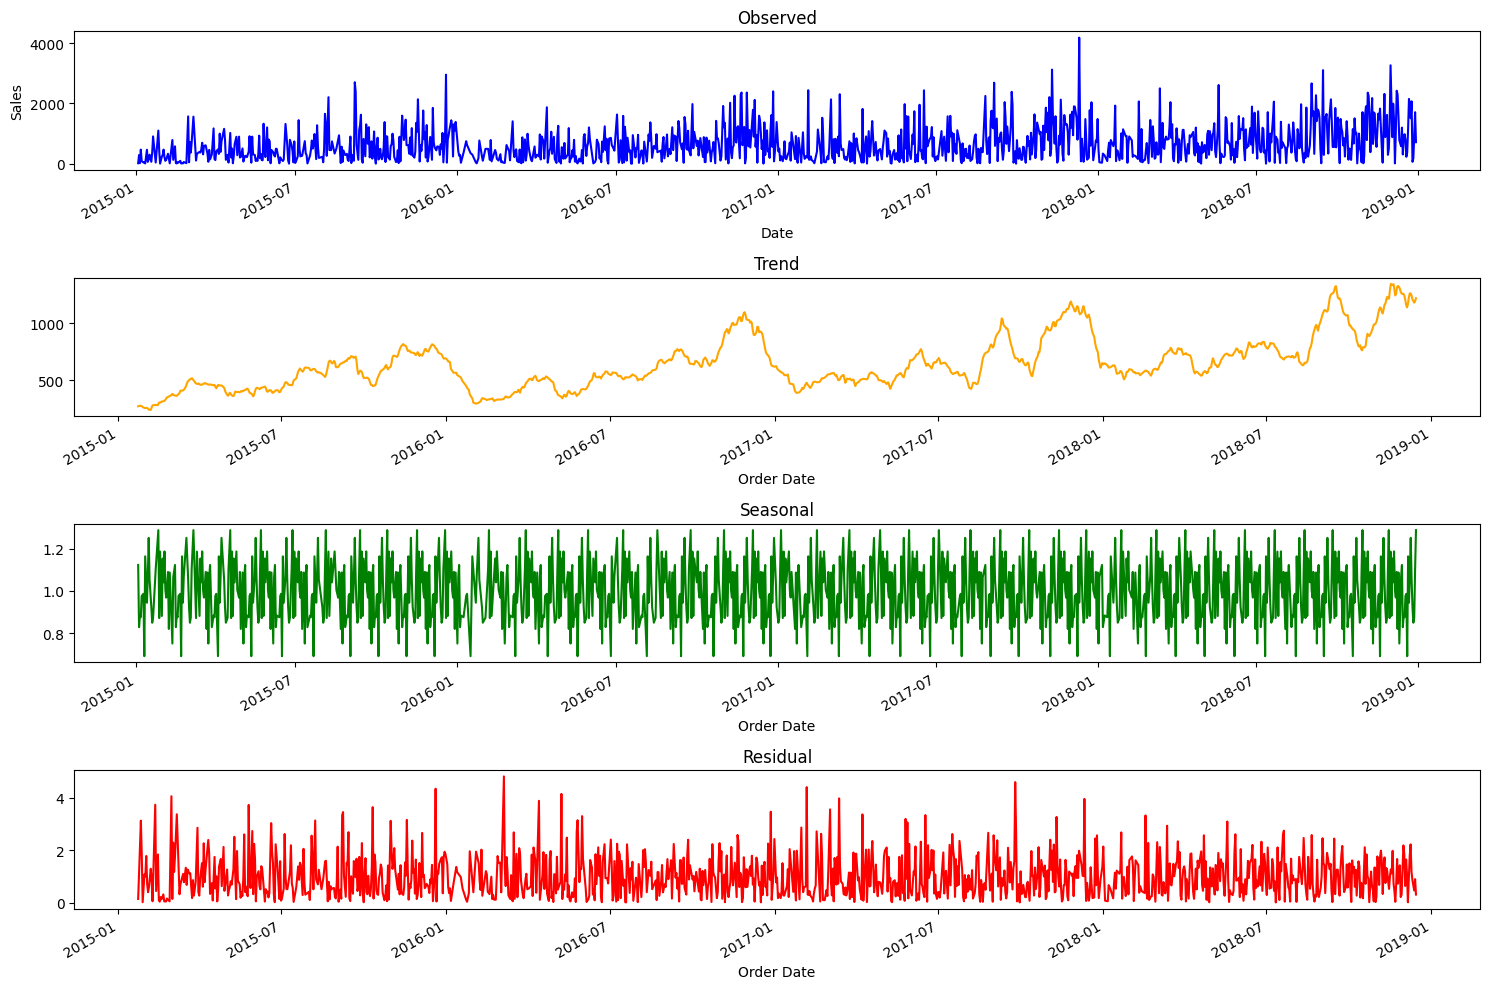

In [ ]:
# Decomposition
decomposition = seasonal_decompose(daily_sales['Sales'], model='multiplicative', period = 30)

#Decomposition plot

fig, axes = plt.subplots(4,1, figsize=(15,10))

decomposition.observed.plot(ax=axes[0], color = 'blue')
axes[0].set_title('Observed')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')

decomposition.trend.plot(ax=axes[1], color = 'orange')
axes[1].set_title('Trend')

decomposition.seasonal.plot(ax=axes[2], color = 'green')
axes[2].set_title('Seasonal')

decomposition.resid.plot(ax=axes[3], color = 'red')
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# prepare features and target

encoded_cats = [f'{col}_Encoded' for col in CATEGORICAL_COLS]
time_features = ['Year', 'Month', 'Day', 'Day of Week', 'Delivery Duration','Quarter','WeekOfYear','IsWeekend', 'Month_Sin','Month_Cos','Day_Sin','Day_Cos']
lag_features = [col for col in df_clean.columns if 'Lag' in col or 'Rolling' in col]

FEATURE_COLS = encoded_cats + time_features + lag_features
TARGET_COL = 'Sales'

# Create a temporary DataFrame for feature selection and NaN handling
temp_df = df_clean[FEATURE_COLS + [TARGET_COL]].copy()

# Drop rows with NaN values from the features and target
# These NaNs are primarily due to the lag/rolling features at the beginning of the time series.
temp_df.dropna(inplace=True)

X = temp_df[FEATURE_COLS]
y = temp_df[TARGET_COL]

# The split index should be recalculated based on the cleaned data length
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 6852
Test size: 1714


In [ ]:
# Scale features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#initialize models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
models = {

    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },

    "Random Forest": {
        "model": RandomForestRegressor(
            n_estimators=100,
            random_state=42
        ),
        "params": {}
    },

    "Gradient Boosting": {
        "model": GradientBoostingRegressor(
            n_estimators=100,
            random_state=42
        ),
        "params": {}
    },

    "XGBoost": {
        "model": xgb.XGBRegressor(
            n_estimators=100,
            objective="reg:squarederror",
            random_state=42
        ),
        "params": {}
    },

    "LightGBM": {
        "model": lgb.LGBMRegressor(
            n_estimators=100,
            random_state=42
        ),
        "params": {}
    }
}




In [ ]:
best_models = {}

for model_name, model_details in models.items():

    print(f"Training {model_name}")

    grid = GridSearchCV(
        estimator=model_details["model"],
        param_grid=model_details["params"],
        cv=3,
        scoring="neg_mean_squared_error"
    )

    grid.fit(X_train, y_train)

    best_models[model_name] = grid.best_estimator_


Training Linear Regression
Training Random Forest
Training Gradient Boosting
Training XGBoost
Training LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 4568, number of used features: 31
[LightGBM] [Info] Start training from score 95.327277
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 4568

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\nFinal Model Evaluation\n")

for model_name, model in best_models.items():

    y_pred = model.predict(X_test)

    print(model_name)
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("MSE :", mean_squared_error(y_test, y_pred))
    print("R2  :", r2_score(y_test, y_pred))
    print("-" * 30)




Final Model Evaluation

Linear Regression
MAE : 72.86936624573603
MSE : 9626.333906166978
R2  : 0.19490866489141934
------------------------------
Random Forest
MAE : 58.829411399066515
MSE : 6822.725957991108
R2  : 0.4293863474775096
------------------------------
Gradient Boosting
MAE : 58.441978148953964
MSE : 6818.667427459062
R2  : 0.42972577968466896
------------------------------
XGBoost
MAE : 62.27605872983026
MSE : 7790.842200933057
R2  : 0.348418659657008
------------------------------
LightGBM
MAE : 57.262099980817126
MSE : 6667.730889771157
R2  : 0.4423492456716501
------------------------------


In [ ]:
comparison_df = pd.DataFrame({
    "Date": X_test.index,     # Date should be index for time series
    "Actual": y_test,
    "Predicted": y_pred
})

comparison_df = comparison_df.sort_values("Date")


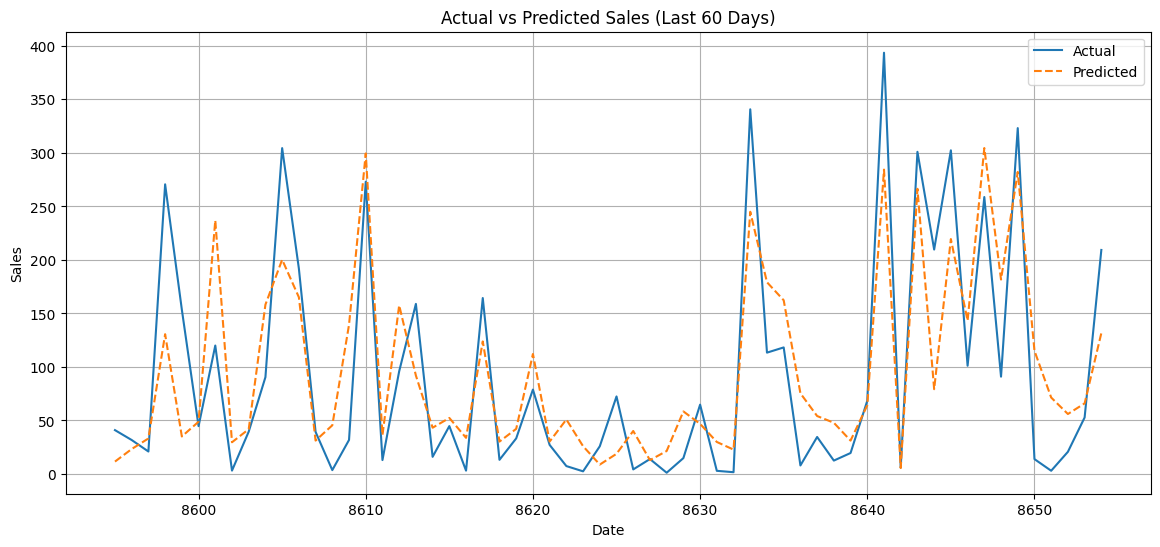

In [ ]:
last_60 = comparison_df.tail(60)

plt.figure(figsize=(14,6))
plt.plot(last_60["Date"], last_60["Actual"], label="Actual")
plt.plot(last_60["Date"], last_60["Predicted"], label="Predicted", linestyle="--")

plt.title("Actual vs Predicted Sales (Last 60 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
#Future Predictions

last_date = df_clean['Order Date'].max()

future_dates = pd.date_range(start=last_date + timedelta(days = 1), periods = 30, freq = 'D')

In [ ]:
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)


In [ ]:
#create future dataframe with proper feature engineering

future_df = pd.DataFrame({'Order Date': future_dates})
future_df['Year'] = future_df['Order Date'].dt.year
future_df['Month'] = future_df['Order Date'].dt.month
future_df['Day'] = future_df['Order Date'].dt.day
future_df['Day of Week'] = future_df['Order Date'].dt.dayofweek
future_df['Delivery Duration'] = (future_df['Order Date'] - last_date).dt.days
future_df['Quarter'] = future_df['Order Date'].dt.quarter
future_df['WeekOfYear'] = future_df['Order Date'].dt.isocalendar().week.astype(int)
future_df['IsWeekend'] = future_df['Order Date'].dt.dayofweek.isin([5, 6]).astype(int)

future_df['Month_Sin'] = np.sin(2 * np.pi * future_df['Month'] / 12)
future_df['Month_Cos'] = np.cos(2 * np.pi * future_df['Month']/ 12)
future_df['Day_Sin'] = np.sin(2 * np.pi * future_df['Day'] / 31)
future_df['Day_Cos'] = np.cos(2 * np.pi * future_df['Day'] / 31)

In [ ]:
for col in FEATURE_COLS:
  if col not in future_df.columns:
    if col in df_clean.columns:
      future_df[col] = df_clean[col].mean()

    else:
      #fallback to 0
      future_df[col] = 0

In [ ]:
#Ensuring that the column order matches in X_train's column
future_df = future_df[FEATURE_COLS]

In [ ]:
future_df_scaled = scaler.transform(future_df)

In [ ]:
future_predictions_dict = {}

future_predictions_dict = {}

for model_name, model in best_models.items():
    future_predictions_dict[model_name] = model.predict(future_df_scaled)




In [ ]:
future_results_df = pd.DataFrame({'Order Date': future_dates})

for model_name, predictions in future_predictions_dict.items():
    future_results_df[model_name] = predictions

display(future_results_df.head(15))

,Order Date,Linear Regression,Random Forest,Gradient Boosting,XGBoost,LightGBM
0,2018-12-31,-421.139008,100.842348,192.558883,204.114105,34.562706
1,2019-01-01,-421.620306,101.133848,192.558883,204.114105,34.562706
2,2019-01-02,-423.080357,100.937768,192.558883,211.237625,34.562706
3,2019-01-03,-424.524277,101.125566,192.558883,209.431396,34.562706
4,2019-01-04,-425.941462,100.498546,192.558883,220.596771,34.562706
5,2019-01-05,-419.239825,98.189094,192.558883,216.886307,34.562706
6,2019-01-06,-420.576503,96.645536,191.965697,216.886307,34.562706
7,2019-01-07,-427.506817,98.225008,191.965697,216.886307,34.562706
8,2019-01-08,-428.738395,97.480808,191.965697,216.886307,34.562706
9,2019-01-09,-429.913441,96.227540,191.965697,216.886307,34.562706
